In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

In [3]:
metadata_df = pd.read_excel('./41467_2019_13483_MOESM4_ESM.xlsx', sheet_name='Metadata')
print(metadata_df.shape)
metadata_df = metadata_df[metadata_df['Growth Rate (1/hr)'].isnull() == False]
print(metadata_df.shape)
metadata_df = metadata_df[metadata_df['Growth Rate (1/hr)'] > 0.0]
print(metadata_df.shape)
metadata_df = metadata_df[metadata_df['Alignment'] > 80]
print(metadata_df.shape)

(278, 26)
(195, 26)
(179, 26)
(173, 26)


In [4]:
expression_df = pd.read_excel('./41467_2019_13483_MOESM4_ESM.xlsx', sheet_name='Expression Data', index_col=0)
print(expression_df.shape)
expression_df = expression_df[metadata_df['Sample ID']]
print(expression_df.shape)

(3923, 278)
(3923, 173)


In [5]:
assert list(metadata_df['Sample ID']) == list(expression_df.columns)

In [ ]:
expression_df = expression_df / expression_df.sum()

In [23]:
tempy = []
for index in expression_df.index:
    rho, p = stats.spearmanr(expression_df.loc[index], metadata_df['Growth Rate (1/hr)'])
    tempy.append((index, rho, p))
tempy.sort(key=lambda x: x[1])

In [24]:
tempy

[('b2310', -0.6933705839604442, 4.0266988088158665e-26),
 ('b3588', -0.6591716496471858, 6.23894367950203e-23),
 ('b2341', -0.6506792968311417, 3.3413825131383392e-22),
 ('b1423', -0.6488141322555188, 4.796180666583987e-22),
 ('b2537', -0.6481325183521834, 5.469985323212998e-22),
 ('b3995', -0.642333004137241, 1.6516578853560105e-21),
 ('b1517', -0.6412630557821757, 2.0199452220609328e-21),
 ('b1976', -0.6407657558424973, 2.2174489856803686e-21),
 ('b3570', -0.6393237019381623, 2.903456666191109e-21),
 ('b0330', -0.6391973483404351, 2.972642890523314e-21),
 ('b0221', -0.6387533719374124, 3.2288036423404356e-21),
 ('b0953', -0.6359353389459024, 5.439262191247258e-21),
 ('b3688', -0.6320763377822918, 1.1013798933616377e-20),
 ('b1518', -0.6307899204389755, 1.390340821659883e-20),
 ('b1443', -0.6297347389987251, 1.6817626330227144e-20),
 ('b1444', -0.6296211366815025, 1.716498124969148e-20),
 ('b0346', -0.6218347411224844, 6.832507003637724e-20),
 ('b1487', -0.6190410514846647, 1.11113628

In [ ]:
a = metadata_df['Growth Rate (1/hr)']
b = expression_df.sum()

fig, ax = plt.subplots()
ax.scatter(a,b)

In [ ]:
metadata_df['Growth Rate (1/hr)'].hist()

In [ ]:
tempy = []
for column in expression_df.columns:
    rho, p = stats.spearmanr(expression_df[expression_df.columns[0]], expression_df[column])
    tempy.append((column, rho, p))
tempy.sort(key=lambda x: x[1])

In [ ]:
tempy

In [6]:
other_df = pd.read_csv('../Phage_translation/Data/562_associated_data/ecoli.combined.tsv', sep='\t', index_col=7)

In [ ]:
other_df

In [7]:
print(expression_df.shape)
expression_df = expression_df[expression_df.index.isin(other_df.index)]
print(expression_df.shape)
other_df = other_df[other_df.index.isin(expression_df.index)]
print(other_df.shape)

(3923, 173)
(3730, 173)
(3730, 21)


In [8]:
expression_df = expression_df.sort_index()
other_df = other_df.sort_index()

In [22]:
tempy = []
listy_a = []
listy_b = []
for column in expression_df.columns:
    a, b, c, d, e = stats.linregress(other_df['sec_struct'], expression_df[column])
    listy_a.append(c)
    listy_b.append(metadata_df[metadata_df['Sample ID']==column].iloc[0]['Growth Rate (1/hr)'])
    tempy.append((column, rho, p))
#     rho, p = stats.spearmanr(other_df['iCUB'], expression_df[column])
#     listy_a.append(rho)
#     listy_b.append(metadata_df[metadata_df['Sample ID']==column].iloc[0]['Growth Rate (1/hr)'])
#     tempy.append((column, rho, p))
tempy.sort(key=lambda x: x[1])

SpearmanrResult(correlation=-0.04846645799055438, pvalue=0.5265850385456408)


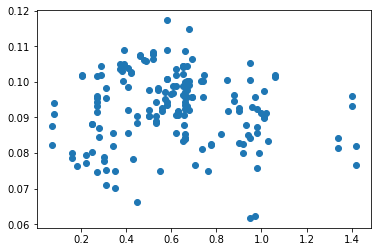

In [21]:
fig, ax = plt.subplots()
ax.scatter(listy_b, listy_a)
print(stats.spearmanr(listy_b, listy_a))

In [ ]:
tempy

In [ ]:
other_df.columns

In [13]:
expression_df

,fur__wt_fe__1,fur__wt_fe__2,fur__delfur_fe2__1,fur__delfur_fe2__2,omics__bw_ac__1,omics__bw_ac__2,omics__bw_fum__1,omics__bw_fum__2,omics__bw_glc__1,omics__bw_glc__2,...,efeU__menFentC_ale29__1,efeU__menFentC_ale29__2,efeU__menFentC_ale30__1,efeU__menFentC_ale30__2,efeU__menFentCubiC_ale36__1,efeU__menFentCubiC_ale36__2,efeU__menFentCubiC_ale37__1,efeU__menFentCubiC_ale37__2,efeU__menFentCubiC_ale38__1,efeU__menFentCubiC_ale38__2
log-TPM,,,,,,,,,,,,,,,,,,,,,
b0002,11.064810,10.779071,11.229767,11.214065,9.257348,9.182322,9.709213,9.672126,10.208587,10.218351,...,10.271327,10.276565,11.148538,11.170578,11.676604,11.726097,11.881529,11.923237,11.496410,11.552762
b0003,10.776984,10.597810,10.897938,10.861157,8.983408,8.943151,9.436004,9.394573,9.609637,9.677931,...,10.160291,10.116861,10.314322,10.392251,10.916426,10.909277,11.023924,11.038426,10.624301,10.764195
b0004,10.394971,10.113950,10.185151,10.164655,8.761690,8.779920,9.532673,9.534370,9.883558,9.870356,...,10.475069,10.434352,10.679541,10.723953,11.143310,11.112721,11.184795,11.241845,10.953206,11.001006
b0005,6.716069,6.410864,6.527653,6.136168,4.474204,4.720490,5.782102,5.326669,5.846675,5.972022,...,5.979079,5.705586,6.306120,6.291340,5.058537,4.835550,5.448097,5.757951,5.873964,5.808618
b0006,6.761813,6.816532,6.862147,6.817480,6.536457,6.439917,6.408731,6.276017,6.910200,6.843384,...,8.371287,8.322390,8.137515,8.071837,7.354131,7.365536,7.328101,7.314761,8.057750,8.105213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4661,2.983566,2.891681,3.014653,3.138444,3.646932,3.761719,3.620130,3.649078,3.694585,3.680561,...,3.489289,3.869028,3.308874,2.964893,3.190216,3.295865,3.466941,3.605560,3.588887,3.508282
b4662,2.461686,2.308173,2.490832,2.811756,2.721436,4.173855,4.782252,3.710787,4.448067,4.589002,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.550507,1.487121,0.000000,0.000000,0.000000
b4676,2.458731,3.525292,3.555255,3.946282,3.989454,3.097347,4.489751,3.176679,3.648677,4.278558,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [25]:
listy = []
for index in expression_df.index:
    rho, p = stats.spearmanr(expression_df.loc[index], metadata_df['Growth Rate (1/hr)'])
    listy.append(rho)
other_df['hunch'] = listy

SpearmanrResult(correlation=-0.23515250697893833, pvalue=4.937887365652629e-48)


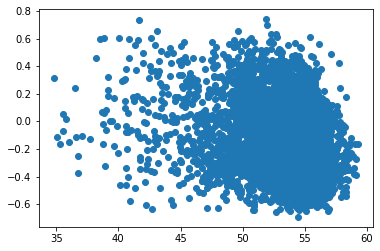

In [32]:
fig, ax = plt.subplots()
ax.scatter(other_df['iCUB'], other_df['hunch'])
print(stats.spearmanr(other_df['iCUB'], other_df['hunch']))

SpearmanrResult(correlation=0.04569411046135154, pvalue=0.0052507801370892514)


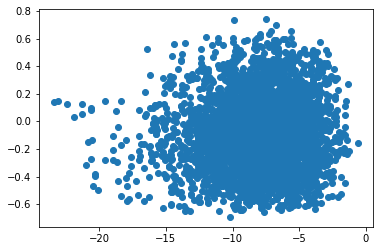

In [31]:
fig, ax = plt.subplots()
ax.scatter(other_df['Start_accessibility'], other_df['hunch'])
print(stats.spearmanr(other_df['Start_accessibility'], other_df['hunch']))

SpearmanrResult(correlation=-0.05775832810906073, pvalue=0.0004166914462606806)


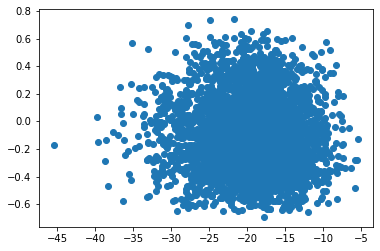

In [34]:
fig, ax = plt.subplots()
ax.scatter(other_df['sec_struct'], other_df['hunch'])
print(stats.spearmanr(other_df['sec_struct'], other_df['hunch']))

SpearmanrResult(correlation=0.0764867793082473, pvalue=2.916439887056762e-06)


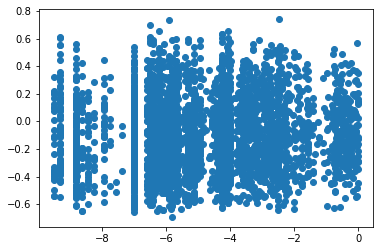

In [35]:
fig, ax = plt.subplots()
ax.scatter(other_df['aSD_binding'], other_df['hunch'])
print(stats.spearmanr(other_df['aSD_binding'], other_df['hunch']))